# Tutorial Part 5: Putting Multitask Learning to Work

This notebook walks through the creation of multitask models on MUV [1]. The goal is to demonstrate that multitask methods outperform singletask methods on MUV.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/05_Putting_Multitask_Learning_to_Work.ipynb)


## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
!chmod +x Anaconda3-2019.10-Linux-x86_64.sh
!bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local
!conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-03-07 01:02:20--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   106MB/s    in 4.7s    

2020-03-07 01:02:30 (107 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - anaconda-navigator==1.

The MUV dataset is a challenging benchmark in molecular design that consists of 17 different "targets" where there are only a few "active" compounds per target. The goal of working with this dataset is to make a machine learnign model which achieves high accuracy on held-out compounds at predicting activity. To get started, let's download the MUV dataset for us to play with.

In [2]:
import os
import deepchem as dc

current_dir = os.path.dirname(os.path.realpath("__file__"))
dataset_file = "medium_muv.csv.gz"
full_dataset_file = "muv.csv.gz"

# We use a small version of MUV to make online rendering of notebooks easy. Replace with full_dataset_file
# In order to run the full version of this notebook
dc.utils.download_url("https://s3-us-west-1.amazonaws.com/deepchem.io/datasets/%s" % dataset_file,
                      current_dir)

dataset = dc.utils.save.load_from_disk(dataset_file)
print("Columns of dataset: %s" % str(dataset.columns.values))
print("Number of examples in dataset: %s" % str(dataset.shape[0]))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Columns of dataset: ['MUV-466' 'MUV-548' 'MUV-600' 'MUV-644' 'MUV-652' 'MUV-689' 'MUV-692'
 'MUV-712' 'MUV-713' 'MUV-733' 'MUV-737' 'MUV-810' 'MUV-832' 'MUV-846'
 'MUV-852' 'MUV-858' 'MUV-859' 'mol_id' 'smiles']
Number of examples in dataset: 10000


Now, let's visualize some compounds from our dataset

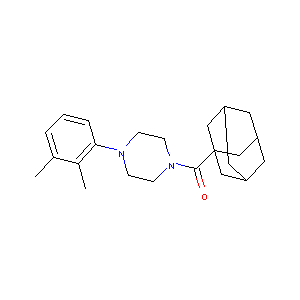

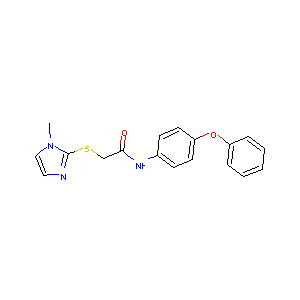

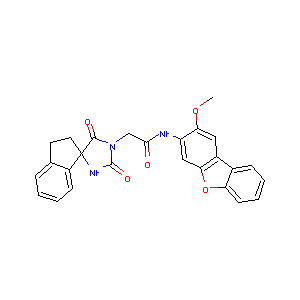

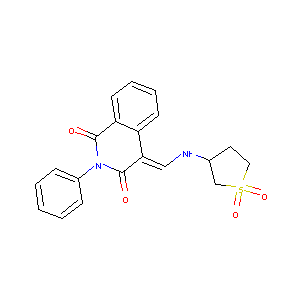

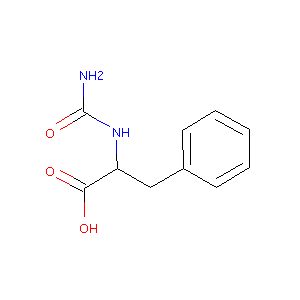

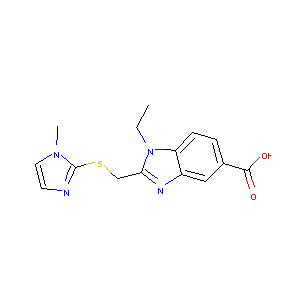

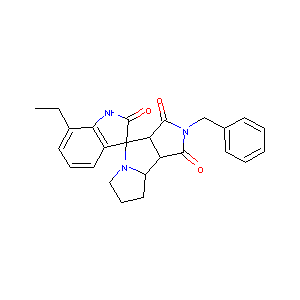

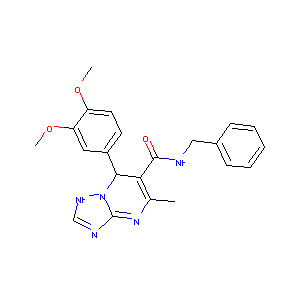

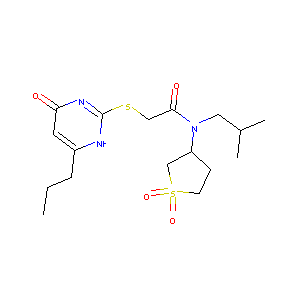

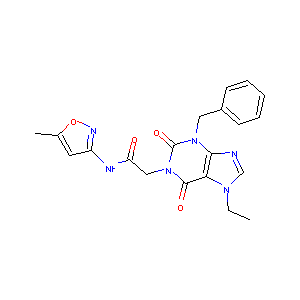

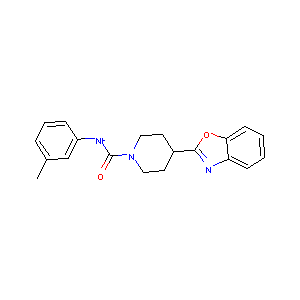

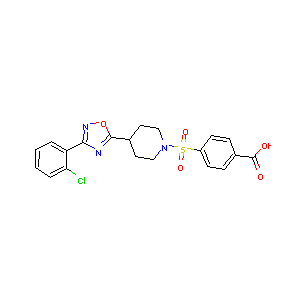

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display, HTML

def display_images(filenames):
    """Helper to pretty-print images."""
    for filename in filenames:
        display(Image(filename))

def mols_to_pngs(mols, basename="test"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "MUV_%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

num_to_display = 12
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))
display_images(mols_to_pngs(molecules))

There are 17 datasets total in MUV as we mentioned previously. We're going to train a multitask model that attempts to build a joint model to predict activity across all 17 datasets simultaneously. There's some evidence [2] that multitask training creates more robust models. 

As fair warning, from my experience, this effect can be quite fragile. Nonetheless, it's a tool worth trying given how easy DeepChem makes it to build these models. To get started towards building our actual model, let's first featurize our data.

In [4]:
MUV_tasks = ['MUV-692', 'MUV-689', 'MUV-846', 'MUV-859', 'MUV-644',
             'MUV-548', 'MUV-852', 'MUV-600', 'MUV-810', 'MUV-712',
             'MUV-737', 'MUV-858', 'MUV-713', 'MUV-733', 'MUV-652',
             'MUV-466', 'MUV-832']

featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
      tasks=MUV_tasks, smiles_field="smiles",
      featurizer=featurizer)
dataset = loader.featurize(dataset_file)

Loading raw samples now.
shard_size: 8192
About to start loading CSV from medium_muv.csv.gz
Loading shard 1 of size 8192.
Featurizing sample 0
Featurizing sample 1000
Featurizing sample 2000
Featurizing sample 3000
Featurizing sample 4000
Featurizing sample 5000
Featurizing sample 6000
Featurizing sample 7000
Featurizing sample 8000
TIMING: featurizing shard 0 took 33.958 s
Loading shard 2 of size 8192.
Featurizing sample 0
Featurizing sample 1000
TIMING: featurizing shard 1 took 7.484 s
TIMING: dataset construction took 41.956 s
Loading dataset from disk.


We'll now want to split our dataset into training, validation, and test sets. We're going to do a simple random split using `dc.splits.RandomSplitter`. It's worth noting that this will provide overestimates of real generalizability! For better real world estimates of prospective performance, you'll want to use a harder splitter.

In [5]:
splitter = dc.splits.RandomSplitter(dataset_file)
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
    dataset)
#NOTE THE RENAMING:
valid_dataset, test_dataset = test_dataset, valid_dataset

Computing train/valid/test indices
TIMING: dataset construction took 0.636 s
Loading dataset from disk.
TIMING: dataset construction took 0.299 s
Loading dataset from disk.
TIMING: dataset construction took 0.306 s
Loading dataset from disk.


Let's now get started building some models!  We'll do some simple hyperparameter searching to build a robust model.

In [6]:
import numpy as np
import numpy.random

params_dict = {"activation": ["relu"],
               "momentum": [.9],
               "batch_size": [50],
               "init": ["glorot_uniform"],
               "data_shape": [train_dataset.get_data_shape()],
               "learning_rate": [1e-3],
               "decay": [1e-6],
               "nb_epoch": [1],
               "nesterov": [False],
               "dropouts": [(.5,)],
               "nb_layers": [1],
               "batchnorm": [False],
               "layer_sizes": [(1000,)],
               "weight_init_stddevs": [(.1,)],
               "bias_init_consts": [(1.,)],
               "penalty": [0.], 
              } 


n_features = train_dataset.get_data_shape()[0]
def model_builder(model_params, model_dir):
  model = dc.models.MultitaskClassifier(
    len(MUV_tasks), n_features, **model_params)
  return model

metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
optimizer = dc.hyper.HyperparamOpt(model_builder)
best_dnn, best_hyperparams, all_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, [], metric)

Fitting model 1/1
hyperparameters: {'activation': 'relu', 'momentum': 0.9, 'batch_size': 50, 'init': 'glorot_uniform', 'data_shape': (1024,), 'learning_rate': 0.001, 'decay': 1e-06, 'nb_epoch': 1, 'nesterov': False, 'dropouts': (0.5,), 'nb_layers': 1, 'batchnorm': False, 'layer_sizes': (1000,), 'weight_init_stddevs': (0.1,), 'bias_init_consts': (1.0,), 'penalty': 0.0}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.









/usr/local/lib/python3.7/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/usr/local/lib/python3.7/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/usr/local/lib/python3.7/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))
/usr/local/lib/python3.7/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC

computed_metrics: [nan, nan, nan, 0.29069767441860467, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
Model 1/1, Metric mean-roc_auc_score, Validation set 0: 0.290698
	best_validation_score so far: 0.290698
computed_metrics: [1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Best hyperparameters: ('relu', 0.9, 50, 'glorot_uniform', (1024,), 0.001, 1e-06, 1, False, (0.5,), 1, False, (1000,), (0.1,), (1.0,), 0.0)
train_score: 1.000000
validation_score: 0.290698


/usr/local/lib/python3.7/site-packages/deepchem/metrics/__init__.py:368: UserWarning: Error calculating metric mean-roc_auc_score: Only one class present in y_true. ROC AUC score is not defined in that case.
  warnings.warn("Error calculating metric %s: %s" % (self.name, e))


# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

# Bibliography

[1] https://pubs.acs.org/doi/10.1021/ci8002649

[2] https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00146